# **P4: Recurrent Neural Networks**

### **Introduction**
In this practical project, you will implement a recurrent neural network (RNN) in PyTorch to generate Pokemon names using a character-level language model. First, you will create a class to load the dataset. Second, you will build a traditional RNN. Third, you will train this network using mini-batch gradient descent. Finally, you will use the trained model to generate new Pokemon names.

### **Objective**

The main objective of this project is to practice implementing RNNs in PyTorch, including dataset loading, implementing custom layers, training with gradient descent, and generating with language models.

### **Instructions**

After each cell of this type, there is a test cell followed by expected results, so you can check if your solution is correct. Your results might be slightly diferent from the expected results and still be correct.

### **Part 0: Import libraries**

As in the previous programming, you will import the `torch` library and other  auxiliary libraries.

In [ ]:
import sys
import time
import math
import torch
import string
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### **Part 1: Loading and preprocessing the dataset**

In this first part, you will download the dataset as a txt file (pokemons.txt), which contains names of 890 Pokemon created from the first to the eighth generation of the series. Each name is separated by a \n character.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11JSIFaxEbcdnP5HBezaS8LUdZLUxG7V8' -O pokemons.txt

--2025-10-26 19:20:38--  https://docs.google.com/uc?export=download&id=11JSIFaxEbcdnP5HBezaS8LUdZLUxG7V8
Resolving docs.google.com (docs.google.com)... 142.251.121.102, 142.251.121.139, 142.251.121.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.121.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=11JSIFaxEbcdnP5HBezaS8LUdZLUxG7V8&export=download [following]
--2025-10-26 19:20:39--  https://drive.usercontent.google.com/download?id=11JSIFaxEbcdnP5HBezaS8LUdZLUxG7V8&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.121.132, 2607:f8b0:4023:80b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.121.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9954 (9.7K) [application/octet-stream]
Saving to: ‘pokemons.txt’

pokemons.txt        100%[===================>]   9.72K  --.-KB/s    

#### **1.1 Download data and create vocabulary**

Read the 'pokemons.txt' file to load all pokemon names from Generation 1 through Generation 8 in a list and produce the train/test sets randomly using a 80/20 split. Moreover, create a vocabulary (list) with all the characters in the text file sorted alphabetically. Make sure to include three extra control characters in your vocabulary: '[' (SOS), ']' (EOS), '@' (padding)

In [ ]:
random.seed(42)

# Read names, keeping newline characters initially for vocab creation
file_path = "pokemons.txt"
try:
    with open(file_path, 'r', encoding='utf-8') as f: # Added encoding for safety
        names = f.readlines() # Keep '\n'
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Make sure it was downloaded correctly.")
    names = [] # Set to empty list to avoid further errors

# Shuffle names if the list is not empty
if names:
    random.shuffle(names)

# Randomly split the dataset using a 80/20 split
split_index = int(0.8 * len(names))
train_text_raw = names[:split_index]
test_text_raw = names[split_index:]

# Create vocabulary from the raw names (including '\n')
all_chars = set()
for name in names:
    all_chars.update(list(name))

# Add special characters as instructed (even if not in first 10 expected)
special_chars = ['[', ']', '@']
all_chars.update(special_chars)

# Sort alphabetically to create the final vocabulary
vocab = sorted(list(all_chars))

# Prepare stripped versions for printing (matching expected output format)
train_text = [name.strip() for name in train_text_raw]
test_text = [name.strip() for name in test_text_raw]

# Print the results
print("First 5 training examples:", train_text[:5])
print("First 5 test examples:", test_text[:5])
print("First 10 characters of vocabulary:", vocab[:10])
print("Vocabulary size", len(vocab))

First 5 training examples: ['Revavroom', 'Rattata', 'Sudowoodo', 'Piplup', 'Mewtwo']
First 5 test examples: ['Koffing', 'Tranquill', 'Marill', 'Jangmo-o', 'Pansear']
First 10 characters of vocabulary: ['\n', ' ', "'", '-', '.', '2', '@', 'A', 'B', 'C']
Vocabulary size 67


**Expected result**:

<table style="width:50%">
  <tr>
    <td> First 5 training examples </td>
    <td>['Shellos', 'Haunter', 'Ninjask', 'Snover', 'Araquanid']</td>
  </tr>
  <tr>
    <td> First 5 test examples </td>
    <td>['Pansear', 'Dracovish', 'Charmander', 'Zeraora', 'Furret']</td>
  </tr>
  <tr>
    <td> First 10 characters of vocabulary </td>
    <td>['\n', ' ', "'", '-', '.', '2', ':', '@', 'A', 'B']</td>
  </tr>
    <tr>
    <td> Vocabulary Size </td>
    <td> 65</td>
  </tr>
</table>

#### **1.2 Create a Dataset class to store the dataset**

PyTorch provides the [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class for loading datasets from files. To create a custom dataset, you need to extend the Dataset class and implement three functions: `__init__`, `__len__`, and `__getitem__`. In this step, you will implement these three functions and some auxiliary ones to build a dataset for your Pokemon names language model.

- `__init__`:
  Initialize the dataset by creating attributes to store the names and the vocab. Add SOS/EOS tokens to each name before storing them. Morever, create mappings between characters and indices and vice versa. It is also useful to compute and store the max len of a word in the dataset.

- `one_hot_encode(ix)`:
  Create a one-hot encoded tensor for a given index.

- `encode(seq_ch)`:
  Convert a sequence of characters into a tensor of one-hot vectors.

- `decode(seq_ix)`:
  Convert a sequence of indices back into a string of characters.

- `__len__`:
  Return the total number of sequences in the dataset.

- `__getitem__(index)`:
  Process a single Pokemon name by padding (with @) to match the longest sequence length, and returning input-output tensor pairs. Use `torch.tensor()` to convert the output sequence to a tensor.

Remember that for language modeling, your input sequences (`x`) should be shifted by one character relative to your target sequences (`y`), allowing the model to predict the next character in the sequence.

In [ ]:
class INF721Dataset(Dataset):
    def __init__(self, names, vocab):
        """
        Initializes the dataset.
        Args:
            names (list): List of strings (Pokemon names).
            vocab (list): List of unique characters constituting the vocabulary.
        """
        # create vocabulary of chars and mappings
        self.vocab = vocab
        self.ch2ix = {ch: i for i, ch in enumerate(vocab)} # Character to index mapping
        self.ix2ch = {i: ch for i, ch in enumerate(vocab)} # Index to character mapping

        # create samples, adding SOS and EOS tokens
        self.sequences = ['[' + name + ']' for name in names]

        # compute and store the max length of a sequence in this dataset
        self.max_len = 0
        if self.sequences: # Calculate max_len only if there are sequences
            self.max_len = max(len(s) for s in self.sequences)

    def one_hot_encode(self, ix):
        """
        Create a one-hot encoded tensor for a given index.
        Args:
            ix (int): The index to encode.
        Returns:
            torch.Tensor: A one-hot encoded tensor of shape (vocab_size).
        """
        # Use PyTorch's functional one_hot
        return F.one_hot(torch.tensor(ix), num_classes=self.vocab_size).float()

    def encode(self, seq_ch):
        """
        Convert a sequence of characters into a tensor of one-hot vectors.
        Args:
            seq_ch (str): A string representing the sequence of characters to encode.
        Returns:
            torch.Tensor: A tensor of one-hot vectors of shape (seq_len, vocab_size).
        """
        # Map characters to indices
        indices = [self.ch2ix[ch] for ch in seq_ch]
        # Convert list of indices to one-hot tensor
        return F.one_hot(torch.tensor(indices), num_classes=self.vocab_size).float()

    def decode(self, seq_ix):
        """
        Convert a sequence of indices (or a tensor of indices) back into a string.
        Args:
            seq_ix (list or torch.Tensor): A list/tensor of indices.
        Returns:
            str: The decoded string of characters.
        """
        # Handle tensor input by converting to list if necessary
        if isinstance(seq_ix, torch.Tensor):
            seq_ix = seq_ix.tolist()
        # Map indices back to characters and join
        return "".join([self.ix2ch.get(ix, '?') for ix in seq_ix]) # Use .get for safety

    def __len__(self):
        """
        Get the total number of sequences in the dataset.
        Returns:
            int: The total number of sequences.
        """
        return len(self.sequences)

    def __getitem__(self, index):
        """
        Get a single padded sample (input x, target y) from the dataset.
        Args:
            index (int): Index of the sample to retrieve.
        Returns:
            tuple: (x, y) where x is the one-hot encoded input sequence (shape: max_len-1, vocab_size)
                   and y is the target index sequence (shape: max_len-1).
        """
        sequence = self.sequences[index]

        # Pad sequence to max_len with '@' character
        pad_len = self.max_len - len(sequence)
        padded_sequence = sequence + '@' * pad_len

        # Convert padded sequence to indices
        indices = [self.ch2ix[ch] for ch in padded_sequence]

        # Input sequence x: one-hot encoded indices from SOS up to the second-to-last character
        x_indices = indices[:-1]
        x = F.one_hot(torch.tensor(x_indices), num_classes=self.vocab_size).float()

        # Target sequence y: indices from the first character up to EOS
        y_indices = indices[1:]
        y = torch.tensor(y_indices, dtype=torch.long) # CrossEntropyLoss expects Long indices

        return x, y

    @property
    def vocab_size(self):
        """
        Get the size of the vocabulary.
        Returns:
            int: The size of the vocabulary.
        """
        return len(self.vocab)

In [ ]:
train_dataset = INF721Dataset(train_text, vocab)
test_dataset = INF721Dataset(test_text, vocab)

print("Train vocabulary size:", train_dataset.vocab_size)
print("Test vocabulary size:", test_dataset.vocab_size)

print("Train max sequence length:", train_dataset.max_len)
print("Test max sequence length:", test_dataset.max_len)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train vocabulary size: 67
Test vocabulary size: 67
Train max sequence length: 19
Test max sequence length: 16
Train dataset size: 819
Test dataset size: 205


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Train vocabulary size </td>
    <td>65</td>
  </tr>
  <tr>
    <td> Test vocabulary size </td>
    <td>65</td>
  </tr>
  <tr>
    <td> Train max sequence length </td>
    <td>14</td>
  </tr>
  <tr>
    <td> Test max sequence length </td>
    <td>13</td>
  </tr>
  <tr>
    <td> Train dataset size </td>
    <td>712</td>
  </tr>
    <tr>
    <td> Test dataset size </td>
    <td>178</td>
  </tr>
</table>

#### **1.3 Visualization of examples**

If you loaded the data correctly, you can use the code below to visualize examples from the dataset.

In [ ]:
x = train_dataset.sequences[0]
x_encoded, y = train_dataset[0]
print("x0", x)
print("x0_encoded size", x_encoded.size())
print("y", y)

x0 [Revavroom]
x0_encoded size torch.Size([18, 67])
y tensor([24, 39, 56, 35, 56, 52, 49, 49, 47, 34,  6,  6,  6,  6,  6,  6,  6,  6])


**Expected result**:

<table style="width:50%">
  <tr>
    <td>x0</td>
    <td>[Shellos]</td>
  </tr>
  <tr>
    <td>x0 encoded size</td>
    <td>[13, 65]</td>
  </tr>
  <tr>
    <td> y </td>
    <td>[26, 43, 40, 47, 47, 50, 54, 35,  7,  7,  7,  7,  7]</td>
  </tr>
</table>

#### **1.4 Create a DataLoader to iterate through examples**

 Create a `train_loader` and a `test_loader` using PyTorch's [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training and test set. Configure both of them with:
- batch_size = 32
- drop_last = True (to remove the last potentially incomplete minibatch)

Make sure to set shuffle parameter to True in your training data loader. You don't need to shuffle the test data loader.


In [ ]:
# Create training data loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

# Create test data loader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=True
)

In [ ]:
torch.manual_seed(1)

# Assuming the variable train_loader have been defined in the previous cell.
train_x_batch, train_y_batch = next(iter(train_loader))
test_x_batch, test_y_batch = next(iter(test_loader))

print("A single training batch size: ", train_x_batch.size())
print("A single test batch size: ", test_x_batch.size())

print("Train Sanity check: ", train_x_batch[0][1])
print("Test Sanity check: ", test_x_batch[0][1])

A single training batch size:  torch.Size([32, 18, 67])
A single test batch size:  torch.Size([32, 15, 67])
Train Sanity check:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Test Sanity check:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Single training batch size </td>
    <td>[32, 13, 65]</td>
  </tr>
  <td> Single test batch size </td>
    <td>[32, 12, 65]</td>
  </tr>
  <tr>
    <td> Train Sanity check </td>
    <td>[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    </td>
  </tr>
    <tr>
    <td> Test Sanity check </td>
    <td>[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    </td>
  </tr>
</table>

## **Part 2: Recurrent Neural Network**

Now that you have a dataset ready for training, it's time to create your RNN.

#### **2.1 Recurrent Hidden Layer**

The first step to create your RNN is to implement a class that extends `torch.nn.Module` with `__init__` to initialize the RNN weights and `forward(x)` for input propagation.

- Weight initialization (`__init__`):
  Use [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) to initialize the RNN weights:
  - `self.Wx`: input weights
  - `self.Wh`: hidden state weights
  - `self.b`: bias
  
  Initialize weights with small random values (`torch.randn * 0.01`) and bias with zeros (`torch.zeros`).

- Forward propagation (`forward(x)`):
  Implement the RNN forward pass (for the hidden layear only) following this equation:

  \begin{align}
    h^{<t>} &= tanh(W_{h} h^{<t-1>} + W_{x}x^{<t>} + b) \\
  \end{align}
  where:
  - x_t is the input at time t
  - h_t is the hidden state at time t
  - Wx, Wh, and b are the learnable parameters

  Remember to:
  1. Handle the initial hidden state case
  2. Process input sequence from left to right
  3. Use `torch.cat` to combine hidden states
  4. Use `permute` to arrange the output tensor in the format (batch_size, seq_len, hidden_size)

In [ ]:
class INF721RNNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Initialize the RNN layer.

        Args:
            input_size (int): The number of expected features in the input x (vocab_size).
            hidden_size (int): The number of features in the hidden state h.
        """
        super(INF721RNNLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Initialize weights and bias as learnable parameters
        self.Wx = nn.Parameter(torch.randn(hidden_size, input_size) * 0.01)
        self.Wh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.01)
        self.b = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev):
        """
        Forward pass of the RNN layer for the entire sequence.

        Args:
            x (torch.Tensor): Input tensor (one-hot vectors) of shape (batch_size, sequence_length, input_size).
            h_prev (torch.Tensor or None): Initial hidden state tensor of shape (batch_size, hidden_size).
                                         If None, it's initialized to zeros.

        Returns:
            outputs (torch.Tensor): Tensor containing the hidden state for each time step,
                                    shape (batch_size, sequence_length, hidden_size).
            h_t (torch.Tensor): The final hidden state after processing the entire sequence,
                                shape (batch_size, hidden_size).
        """
        # Get batch size and sequence length from input tensor x
        batch_size, seq_len, _ = x.shape

        # Initialize hidden state with zeros if not provided
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_size, device=x.device) # Ensure it's on the same device as input

        # List to store hidden states at each time step
        outputs = []

        # Process sequence step by step
        for t in range(seq_len):
            # Get input for the current time step
            x_t = x[:, t, :] # Shape: (batch_size, input_size)

            # Calculate the next hidden state using the RNN formula
            # h_t = tanh(Wx @ x_t.T + Wh @ h_{t-1}.T + b) - adjusted for batch processing
            # Using matrix multiplication: (input @ weight.T + bias)
            h_t = torch.tanh(x_t @ self.Wx.T + h_prev @ self.Wh.T + self.b) # Shape: (batch_size, hidden_size)

            # Store the current hidden state
            outputs.append(h_t)

            # Update the previous hidden state for the next step
            h_prev = h_t

        # Stack the list of hidden states along the sequence dimension
        # Resulting shape: (seq_len, batch_size, hidden_size)
        outputs_tensor = torch.stack(outputs, dim=0)

        # Permute dimensions to get (batch_size, seq_len, hidden_size)
        outputs_tensor = outputs_tensor.permute(1, 0, 2)

        # Return all hidden states and the final hidden state
        return outputs_tensor, h_t

In [ ]:
torch.manual_seed(1)

rnn_layer = INF721RNNLayer(input_size=train_dataset.vocab_size, hidden_size=10)
x, y = train_dataset[0]

with torch.no_grad():
  outputs, hidden = rnn_layer(x.unsqueeze(0), None)

print("Outputs size:", outputs.size())
print("Last hidden state:", hidden)

Outputs size: torch.Size([1, 18, 10])
Last hidden state: tensor([[-0.0097, -0.0018,  0.0228, -0.0002,  0.0074,  0.0019, -0.0064, -0.0046,
          0.0102, -0.0024]])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> **Outputs size** </td>
    <td>[1, 13, 10]</td>
  </tr>
  <tr>
    <td> **Last hidden state** </td>
    <td>[[[-0.0159, -0.0070, -0.0190, -0.0087, 0.0080, -0.0072, -0.0066,
          -0.0208, -0.0029, 0.0080]]]</td>
  </tr>
</table>

####**2.2 Language Model**

Use your recurrent layer to define your language model. Extend `torch.nn.Module` to create a language model that can predict the next character in a sequence.

Your model should contain:
- A recurrent layer (from your previous implementation)
- A fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

The architecture should:
- Take one-hot encoded characters as input (size of vocabulary)
- Process them through the RNN layer (produces hidden states)
- Pass the hidden states through a linear layer to predict the next character
- Return both the predictions and the final hidden state

Remember that the linear layer should process the RNN output for each timestep to make character predictions.

Parameters:
- Input size: vocab_size
- Hidden size: as specified by hidden_size parameter
- Output size: vocab_size (to predict probabilities for each possible character)

In [ ]:
class INF721RNNLanguageModel(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size):
        """
        Initializes the RNN Language Model.

        Args:
            vocab_size (int): The size of the character vocabulary.
            hidden_size (int): The number of features in the RNN hidden state.
        """
        super(INF721RNNLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Instantiate custom RNN layer
        self.rnn_layer = INF721RNNLayer(input_size=vocab_size, hidden_size=hidden_size)

        # Instantiate the output Linear layer
        self.linear_output = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, x, hidden):
        """
        Forward pass of the language model.

        Args:
            x (torch.Tensor): Input tensor (one-hot vectors) of shape (batch_size, sequence_length, input_size).
            hidden (torch.Tensor or None): Initial hidden state tensor of shape (batch_size, hidden_size).

        Returns:
            logits (torch.Tensor): Output scores for each character at each time step,
                                   shape (batch_size, sequence_length, vocab_size).
            final_hidden (torch.Tensor): The final hidden state after processing the sequence,
                                         shape (batch_size, hidden_size).
        """
        # Pass the input sequence and initial hidden state through the RNN layer
        rnn_outputs, final_hidden = self.rnn_layer(x, hidden)

        # Apply the linear layer to the RNN outputs for each time step
        logits = self.linear_output(rnn_outputs)

        # Return the output scores (logits) and the last hidden state
        return logits, final_hidden

In [ ]:
torch.manual_seed(1)

x, y = train_dataset[0]

language_model = INF721RNNLanguageModel(vocab_size=train_dataset.vocab_size, hidden_size=10)
with torch.no_grad():
  outputs, hidden = language_model(x.unsqueeze(0), None)

print("Output size:", outputs.size())
print("Hidden state:", hidden)

Output size: torch.Size([1, 18, 67])
Hidden state: tensor([[-0.0097, -0.0018,  0.0228, -0.0002,  0.0074,  0.0019, -0.0064, -0.0046,
          0.0102, -0.0024]])


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Output size </td>
    <td>[1, 13, 65]</td>
  </tr>
  <tr>
    <td> Hidden state </td>
    <td>[[[-0.0159, -0.0070, -0.0190, -0.0087, 0.0080, -0.0072, -0.0066,
          -0.0208, -0.0029, 0.0080]]]</td>
  </tr>
</table>

## **Part 3: Training with Mini-batch Gradient Descent**

In the third step, you will write the training loop for your Pokemon names language model.

####**3.1 Calculate loss on test set**

Before writting the training loop, you will need to implement a function to compute the loss on the test set, so you can store the test error over the training epochs. To compute the loss, run the forward pass for each mini-batch of your test set and sum the losses of each mini-batch. Return the average loss by dividing this sum by the number of mini-batches in the test set.

In [ ]:
def test(model, test_loader):
    """
    Evaluate a given model on a dataset stored in dataloader by computing the average loss.

    Arguments:
    - model (torch.nn.Module): A language model to evaluate.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
        float: The average loss over the test set.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize total loss and loss function
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        # Iterate over batches in the test loader
        for x_batch, y_batch in test_loader:
            # Initialize hidden state (usually zero for testing each batch independently)
            hidden = None

            # Perform the forward pass
            logits, _ = model(x_batch, hidden)

            # Reshape for CrossEntropyLoss: (N, C) and (N)
            logits_flat = logits.view(-1, model.vocab_size)
            y_batch_flat = y_batch.view(-1)

            # Calculate the loss for the current batch
            loss = criterion(logits_flat, y_batch_flat)

            # Accumulate loss
            total_loss += loss.item()

    # Calculate the average loss over all batches
    avg_loss = total_loss / len(test_loader)
    return avg_loss

In [ ]:
torch.manual_seed(1)

language_model = INF721RNNLanguageModel(vocab_size=train_dataset.vocab_size, hidden_size=10)

loss = test(language_model, test_loader)
print("Test loss:", loss)

Test loss: 4.325579643249512


**Expected result**:

<table style="width:50%">
  <tr>
    <td> Test Loss </td>
    <td>4.233950805664063</td>
  </tr>
</table>

####**3.2 Training loop**

The training loop is similar to the previous project, with two key differences:

1. Initialize the hidden vector as `None` at the start of each mini-batch (since names are independent sequences)
2. Add gradient clipping using [`torch.nn.utils.clip_grad_norm_`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) with a maximum norm of 5 before the optimizer step

Training specifications:
- Number of epochs: 100
- Print loss every 10 epochs
- Use provided dataloader for mini-batches
- Reset hidden state for each mini-batch
- Clip gradients before weight updates

Remember to:
- Define your loss function and optimizer
- Track and store training losses
- Apply gradient clipping before optimizer.step()

In [ ]:
def optimize(model, train_loader, test_loader, vocab_size, learning_rate=0.001, num_epochs=100, outpath='inf721net.pth'):
    """
    Train a given model on a dataset stored in dataloader.
    Includes training loop, gradient clipping, periodic testing, and model saving.
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store the average training and testing errors per print interval
    train_losses = []
    test_losses = []

    print_every = 10 # Print status every 10 epochs

    # Loop over epochs
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        num_batches = 0

        # Loop over mini-batches
        for x_batch, y_batch in train_loader:
            hidden = None

            # Zero the gradients
            optimizer.zero_grad()

            logits, hidden = model(x_batch, hidden)

            # Reshape logits and targets for loss calculation
            logits_flat = logits.view(-1, vocab_size)
            y_batch_flat = y_batch.view(-1)

            # Calculate loss
            loss = criterion(logits_flat, y_batch_flat)
            running_train_loss += loss.item()
            num_batches += 1

            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            # Update model parameters
            optimizer.step()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Evaluate on test set and print status every `print_every` epochs
        if (epoch + 1) % print_every == 0:
            avg_test_loss = test(model, test_loader)
            test_losses.append(avg_test_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, "
                  f"Train Loss: {avg_train_loss:}, "
                  f"Test Loss: {avg_test_loss:}")


    # Save the trained model's state dictionary
    torch.save(model.state_dict(), outpath)

    return train_losses, test_losses

In [ ]:
torch.manual_seed(1)

# Create the model
model = INF721RNNLanguageModel(train_dataset.vocab_size, hidden_size=50)

# Train the model
train_losses, test_losses = optimize(model, train_loader, test_loader, train_dataset.vocab_size, num_epochs=100)

Epoch 10/100, Train Loss: 1.6645932340621947, Test Loss: 2.0121397574742637
Epoch 20/100, Train Loss: 1.4660292053222657, Test Loss: 1.802831808725993
Epoch 30/100, Train Loss: 1.3332526874542237, Test Loss: 1.6539469957351685
Epoch 40/100, Train Loss: 1.2672706937789917, Test Loss: 1.5860218207041423
Epoch 50/100, Train Loss: 1.2317612743377686, Test Loss: 1.5480470259984334
Epoch 60/100, Train Loss: 1.2129031467437743, Test Loss: 1.5269231796264648
Epoch 70/100, Train Loss: 1.1918125104904176, Test Loss: 1.5125350952148438
Epoch 80/100, Train Loss: 1.1771709251403808, Test Loss: 1.497148593266805
Epoch 90/100, Train Loss: 1.1602050018310548, Test Loss: 1.4891820351282756
Epoch 100/100, Train Loss: 1.1495842027664185, Test Loss: 1.4832698106765747


**Expected result**:
<table>
    <tr>
        <td> Epoch 10/200</td>
        <td> Train Loss: 2.2395649281415073, Test Loss: 2.4271461009979247</td>
    </tr>
    <tr>
         <td> Epoch 20/200</td>
        <td> Train Loss: 1.912691669030623, Test Loss: 2.1236252069473265</td>
    </tr>
    <tr>
        <td> ...</td>
        <td> ... </td>
        <td> ... </td>
    </tr>
    <tr>
         <td> Epoch 100/100</td>
        <td> Train Loss: 1.5390102646567605, Test Loss: 1.8045806407928466</td>
    </tr>
</table>

####**3.3 Plot learning curve**

Plot the training and test learning curves using matplotlib.

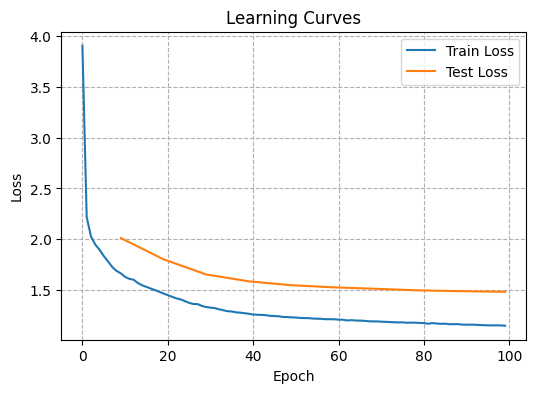

In [ ]:
# Create the x-axis values for the plots
epochs_train = np.arange(len(train_losses)) # 0 to 99
# Test loss was recorded every 10 epochs, starting from epoch 10 (index 9)
epochs_test = np.arange(start=9, stop=len(train_losses), step=10) # 9, 19, 29, ..., 99

# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(epochs_train, train_losses, label='Train Loss')
plt.plot(epochs_test, test_losses, label='Test Loss')

# Add labels and title
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--')

# Display the plot
plt.show()

**Expected result**

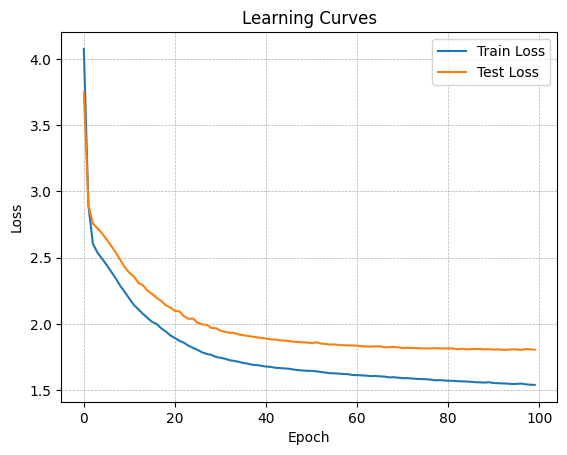

## **Part 4: Sampling from the Language Model**

In the fourth and final part, you will use your trained language model to generate new Pokemon names.

To generate names:

1. Start with a prime string and feed it through the model character by character using the `encode` function from `INF721Dataset` to create one-hot vectors.

2. For character generation:
   - Apply [`torch.nn.functional.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) to the model output to get probabilities
   - Use [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html) for sampling the next character index
   - Convert the index back to a character using the `decode` function

3. Generation loop:
   - Continue generating characters until you encounter the end token `"]"`
   - Feed each generated character back as input for the next prediction
   - Collect all generated characters to form the final name

Parameters to use:
- Prime string: starting sequence for generation
- Temperature: controls randomness in generation (if implemented)
- Model should be in evaluation mode during generation

In [ ]:
def generate(model, text_dataset, prime="["):
    """
    Generate a pokemon name with a given model and a prime sequence.

    Arguments:
    - model (torch.nn.Module): A trained language model to sample names from.
    - text_dataset (torch.utils.data.Dataset): Dataset object with encode/decode methods.
    - prime (str): A prime sequence to start the generation process.

    Returns:
    - pokemon_name (str): a generated pokemon name.
    """
    # Set model to evaluation mode
    model.eval()
    generated_chars = list(prime)
    hidden = None
    max_generate_length = 50

    # Disable gradient calculation
    with torch.no_grad():
        # Prime the RNN hidden state if the prime string is longer than one character
        if len(prime) > 1:
            prime_input_encoded = text_dataset.encode(prime[:-1]).unsqueeze(0)
            _, hidden = model(prime_input_encoded, None)

        # Start generation using the last character of the prime string
        current_char = prime[-1]

        # Generation loop
        for _ in range(max_generate_length):
            # Encode current character, add Batch and Seq dimensions (Seq=1)
            current_input_encoded = text_dataset.encode(current_char).unsqueeze(0)

            # Get model output (logits) and next hidden state
            output_logits, hidden = model(current_input_encoded, hidden)

            # Apply Softmax to get probabilities (remove seq dim first)
            probabilities = F.softmax(output_logits.squeeze(1), dim=1)

            # Sample next character index from the probability distribution
            next_char_index = torch.multinomial(probabilities, num_samples=1).item()

            # Decode index to character
            next_char = text_dataset.decode([next_char_index])

            # Stop if EOS token is generated
            if next_char == ']':
                break
            else:
                # Append generated character and update current character for next step
                generated_chars.append(next_char)
                current_char = next_char
        else:
             # Append indication if max length was reached without EOS
             generated_chars.append('...')

    # Join characters and clean up potential SOS/EOS tokens
    pokemon_name = "".join(generated_chars)
    if pokemon_name.startswith('['):
        pokemon_name = pokemon_name[1:]
    if pokemon_name.endswith(']'):
        pokemon_name = pokemon_name[:-1]

    return pokemon_name

In [ ]:
torch.manual_seed(1)

# Load trained model
model = INF721RNNLanguageModel(train_dataset.vocab_size, hidden_size=50)
model.load_state_dict(torch.load('inf721net.pth'))

n_pokemons = 10
for i in range(n_pokemons):
  p = generate(model, train_dataset)
  print(p)

Camovim
Gaifim
Arthrolu
Bondowea
Kandepa
Komicarruyr
Winasap
Dordeol
Pagtoanim
Sgowfeothe


**Expected result**:
<table>
    <tr>
        <td> [Mamperer]</td>
    </tr>
    <tr>
        <td> [Viitindy]</td>
    </tr>
    <tr>
        <td> [Wonavoraro]</td>
    </tr>
    <tr>
        <td> [Dytlecan]</td>
    </tr>
    <tr>
        <td> [Sninourl]</td>
    </tr>
    <tr>
        <td> [Hootol]</td>
    </tr>
    <tr>
        <td> [Santak]</td>
    </tr>     
    <tr>
        <td> [Parory]</td>
    </tr>
    <tr>
        <td> [heix]</td>
    </tr>   
    <tr>
        <td> [Pogoscorm]</td>
    </tr>                    
</table>

Congratulations! Your language model is ready to generate new Pokemon!

## **Part 6: Generate your own Pokemon**

Use the generate function to create a list of Pokemon names. When you find a name you like, use the Bing Image Generator to illustrate your new Pokemon:

https://www.bing.com/create

Tip: use a prompt like "Generate a fake pokemon named [POKEMON_NAME] in the style of the [GENERATION NUMBER] generation."

Generate a fake pokemon named Bondowea in the style of the 1st generation

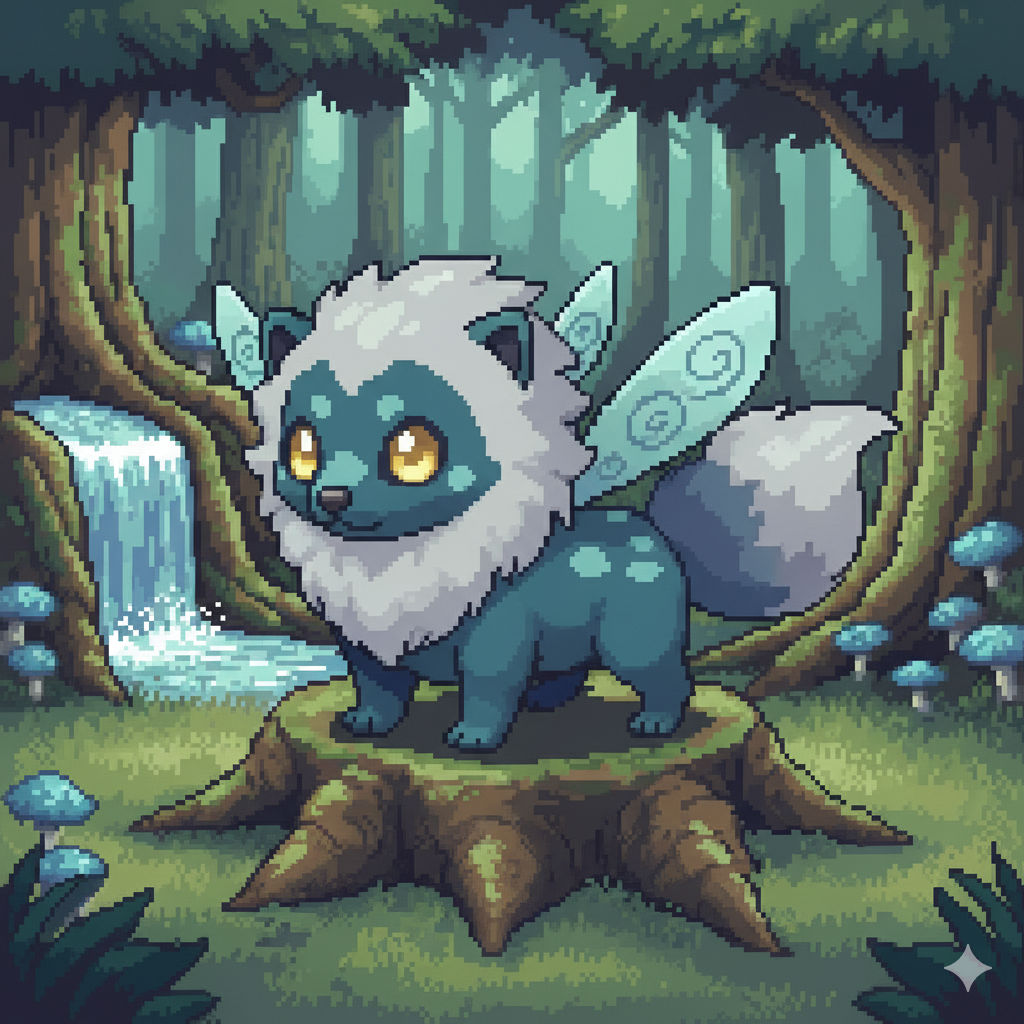

Expected Result:

Generate a fake pokemon named Heix in the style of the 1st generation.

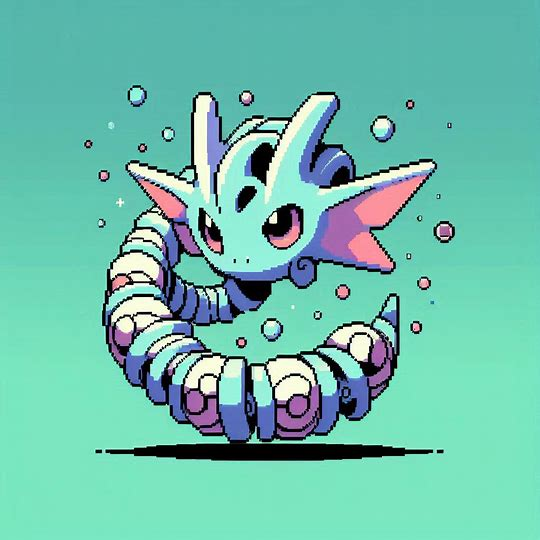

## **Part 6: Challenge (Optional)**

Create an LSTM or a GRU network to build a character-level language model to generate novels like Machado de Assis. You will have access to the training and validation sets, but not to the test set. The model with lower error on the test set will get 1 extra point! You can try any idea we've seen in the course so far to build your model. Report the results with a plot containing the training and validation learning curves, as you did before with the pokemon dataset. Also show the results of some generated novel you were able to produce with your model.

In [ ]:
!wget -O 'machado_train.txt' 'https://raw.githubusercontent.com/JhonataMiranda/CCF482/main/machado_train.txt'
!wget -O 'machado_valid.txt' 'https://raw.githubusercontent.com/JhonataMiranda/CCF482/main/machado_valid.txt'

--2025-10-27 14:42:07--  https://raw.githubusercontent.com/JhonataMiranda/CCF482/main/machado_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1819584 (1.7M) [text/plain]
Saving to: ‘machado_train.txt’

machado_train.txt   100%[===================>]   1.73M  --.-KB/s    in 0.06s   

2025-10-27 14:42:07 (27.8 MB/s) - ‘machado_train.txt’ saved [1819584/1819584]

--2025-10-27 14:42:07--  https://raw.githubusercontent.com/JhonataMiranda/CCF482/main/machado_valid.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 655628 (640K

In [ ]:
train_file_path = "machado_train.txt"
with open(train_file_path, 'r') as file:
  machado_train_text = file.read()

valid_file_path = "machado_valid.txt"
with open(valid_file_path, 'r') as file:
  machado_valid_text = file.read()

print(machado_train_text[:200])
print("----")
print(machado_valid_text[0:200])

Casa Velha

CAPÍTULO PRIMEIRO
ANTES E DEPOIS DA MISSA
Aqui está o que contava, há muitos anos, um velho cônego da Capela
Imperial:
— Não desejo ao meu maior inimigo o que me aconteceu no mês de
abril 
----
Memorial de Aires

Em Lixboa, sobre lo mar,
Barcas novas mandey lavrar...
Cantiga de Joham Zorro.
Para veer meu amigo
Que talhou preyto comigo,
Alá vou, madre.
Para veer meu amado
Que mig’a preyto tal


### **Part 6.1: Setup and Data Preparation**

This section handles the initial setup for the Machado de Assis text generation challenge. It includes:
- Importing necessary libraries (`torch`, `Dataset`, `DataLoader`, `numpy`, `matplotlib`, etc.).
- Defining hyperparameters for the model and training (e.g., `SEQ_LENGTH`, `BATCH_SIZE`, `LEARNING_RATE`, `NUM_EPOCHS`).
- Setting the device (`cuda` or `cpu`).
- Loading the training (`machado_train.txt`) and validation (`machado_valid.txt`) text data.
- Creating a character vocabulary based on the combined text.
- Defining mappings between characters and integer indices (`char_to_int`, `int_to_char`).
- Encoding the raw text data into sequences of integers.
- Implementing the `MachadoDataset` class, which inherits from `torch.utils.data.Dataset` to handle sequence creation (`__getitem__` returns input `x` and target `y` index sequences of length `SEQ_LENGTH`).
- Creating `DataLoader` instances for both training and validation sets to manage batching and shuffling.

In [ ]:
MAX_CHARS_TRAIN = 200000 # Use only the first N chars for training
MAX_CHARS_VALID = 50000  # Use only the first N chars for validation
SEQ_LENGTH = 50     # Shorter sequences
BATCH_SIZE = 64     # Smaller batch size (adjust based on GPU memory)
EMBEDDING_DIM = 128 # Smaller embedding dimension
HIDDEN_SIZE = 256   # Smaller LSTM hidden size
NUM_LAYERS = 1      # Fewer LSTM layers
LEARNING_RATE = 0.002 # Can sometimes use slightly higher LR with smaller models/data
NUM_EPOCHS = 10     # Train for fewer epochs
CLIP_VALUE = 5
PRINT_EVERY = 1     # Print every epoch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = 'machado_lstm_simplified.pth' # Use a different save path

print(f"Using device: {DEVICE}")

# Load Data
try:
    with open("machado_train.txt", 'r', encoding='utf-8') as f:
        full_train_text = f.read()
    with open("machado_valid.txt", 'r', encoding='utf-8') as f:
        full_valid_text = f.read()
    print("Text files loaded successfully.")

    # TAKE ONLY A SUBSET OF THE TEXT
    train_text = full_train_text[:MAX_CHARS_TRAIN]
    valid_text = full_valid_text[:MAX_CHARS_VALID]


    print(f"Using {len(train_text)} chars for training.")
    print(f"Using {len(valid_text)} chars for validation.")

except FileNotFoundError:
    print("Error: machado_train.txt or machado_valid.txt not found.")
    train_text = ""
    valid_text = ""

# Create Vocabulary
combined_subset_text = train_text + valid_text
chars = sorted(list(set(combined_subset_text)))
vocab_size = len(chars)
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
print(f"Vocabulary size (from subset): {vocab_size}")

# Encode Data
train_data_int = [char_to_int[ch] for ch in train_text]
valid_data_int = [char_to_int[ch] for ch in valid_text]

# Machado Dataset Class
class MachadoDataset(Dataset):
    def __init__(self, data_int, seq_length):
        self.data_int = data_int
        self.seq_length = seq_length
        self.num_sequences = len(data_int) - seq_length
    def __len__(self):
        return self.num_sequences
    def __getitem__(self, index):
        x = torch.tensor(self.data_int[index : index + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data_int[index + 1 : index + self.seq_length + 1], dtype=torch.long)
        return x, y

# Create Datasets and DataLoaders
train_dataset = MachadoDataset(train_data_int, SEQ_LENGTH)
valid_dataset = MachadoDataset(valid_data_int, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print(f"Number of training sequences: {len(train_dataset)}")
print(f"Number of validation sequences: {len(valid_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")

Using device: cpu
Text files loaded successfully.
Using 200000 chars for training.
Using 50000 chars for validation.
Vocabulary size (from subset): 98
Number of training sequences: 199950
Number of validation sequences: 49950
Number of training batches: 3124
Number of validation batches: 780


### **Part 6.2: LSTM Model Definition**

Here, the `OptionalModel` class is defined, implementing an LSTM-based character-level language model.
- **`__init__`**: Initializes the model layers:
    - `nn.Embedding`: Converts input character indices into dense vector representations.
    - `nn.LSTM`: The core recurrent layer that processes the sequence of embeddings and maintains hidden/cell states. `batch_first=True` is used for convenient tensor shape handling.
    - `nn.Linear`: A fully connected layer that maps the LSTM's hidden state output at each time step to scores (logits) for each character in the vocabulary.
- **`forward`**: Defines the data flow through the model:
    - Takes input character indices (`x`) and the previous hidden/cell states (`hidden`).
    - Passes indices through the embedding layer.
    - Feeds embeddings and the hidden state into the LSTM layer.
    - Applies the final linear layer to the LSTM outputs to produce logits.
    - Returns the logits and the final hidden/cell states.
- **`init_hidden`**: A helper method to create initial zero tensors for the hidden and cell states, ensuring they are on the correct device.

In [ ]:
class OptionalModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        """
        Initializes the LSTM-based language model.

        Args:
            vocab_size (int): The number of unique characters in the dataset.
            embedding_dim (int): The size of the character embedding vectors.
            hidden_size (int): The number of features in the LSTM hidden state.
            num_layers (int): The number of stacked LSTM layers.
        """
        super(OptionalModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer converts integer indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer processes sequences
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)

        # Final linear layer maps LSTM output to vocabulary scores
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        """
        Forward pass of the LSTM model.

        Args:
            x (torch.Tensor): Input tensor of character indices, shape (batch_size, sequence_length).
            hidden (tuple): Tuple containing the initial hidden state (h_0) and cell state (c_0)
                            for the LSTM, each of shape (num_layers, batch_size, hidden_size).
                            Can be None to initialize with zeros.

        Returns:
            logits (torch.Tensor): Output scores for each character at each time step,
                                   shape (batch_size, sequence_length, vocab_size).
            hidden (tuple): Tuple containing the final hidden state (h_n) and cell state (c_n).
        """
        batch_size = x.size(0)

        # Initialize hidden state if None is provided
        if hidden is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden = (h_0, c_0)

        # Pass input through embedding layer -> (batch, seq, embed_dim)
        embed = self.embedding(x)

        # Pass embeddings through LSTM -> output (batch, seq, hidden_size), hidden (tuple)
        lstm_out, hidden = self.lstm(embed, hidden)

        # Pass LSTM output through linear layer -> (batch, seq, vocab_size)
        logits = self.fc(lstm_out)

        return logits, hidden

    def init_hidden(self, batch_size):
        # Helper to create initial zero hidden state on correct device
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

### **Part 6.3: Training and Validation Functions**

This section defines the functions responsible for training and evaluating the language model.
- **`train_machado`**: Implements the main training loop:
    - Sets the model to training mode (`model.train()`).
    - Iterates through the specified number of `epochs`.
    - Inside each epoch, iterates through mini-batches provided by the `train_loader`.
    - For each batch: resets the hidden state (stateless approach between batches), performs the forward pass, calculates the loss (`nn.CrossEntropyLoss`), computes gradients (`loss.backward()`), applies gradient clipping (`clip_grad_norm_`) to prevent exploding gradients, and updates model weights (`optimizer.step()`).
    - Calls the `test_machado` function periodically (every `print_every` epochs) to evaluate the model on the validation set.
    - Prints training and validation loss, along with validation perplexity (`exp(loss)`).
    - Saves the model (`torch.save`) whenever a lower validation loss is achieved.
    - Returns lists of training and validation losses.
- **`test_machado`**: Calculates the average loss for a given dataset (used for validation during training):
    - Sets the model to evaluation mode (`model.eval()`).
    - Disables gradient calculation (`torch.no_grad()`).
    - Iterates through the batches of the provided `data_loader`.
    - Performs the forward pass and calculates the loss for each batch.
    - Returns the average loss across all batches in the dataset.

In [ ]:
def train_machado(model, train_loader, valid_loader, criterion, optimizer, num_epochs, clip_value, device, model_save_path, print_every):
    """ Trains the LSTM model, performs validation, and saves the best model. """
    print("Start Training")
    start_time = time.time()
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    model.to(device) # Move model to GPU if available

    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        epoch_train_loss = 0
        hidden = model.init_hidden(BATCH_SIZE) # Initialize hidden state for epoch (optional for statefulness)

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device) # Move data to device

            # Detach hidden state from previous batch history (for stateless training between batches)
            hidden = tuple([each.data for each in hidden])

            optimizer.zero_grad() # Reset gradients
            logits, hidden = model(inputs, hidden) # Forward pass

            # Reshape for loss: (batch*seq, vocab_size) and (batch*seq)
            loss = criterion(logits.view(-1, model.vocab_size), targets.view(-1))

            loss.backward() # Compute gradients
            # Clip gradients to prevent exploding gradients
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step() # Update weights

            epoch_train_loss += loss.item()

        # --- Validation Phase ---
        avg_valid_loss = test_machado(model, valid_loader, criterion, device)
        avg_train_loss_epoch = epoch_train_loss / len(train_loader)

        train_losses.append(avg_train_loss_epoch)
        valid_losses.append(avg_valid_loss)

        # Print progress
        if (epoch + 1) % print_every == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch+1}/{num_epochs} | Time: {elapsed_time/60:.2f} min | "
                  f"Train Loss: {avg_train_loss_epoch:.4f} | "
                  f"Valid Loss: {avg_valid_loss:.4f} | "
                  f"Valid PPL: {math.exp(avg_valid_loss):.4f}") # Perplexity

            # Save the model if validation loss has decreased
            if avg_valid_loss < best_valid_loss:
                print(f"Validation loss decreased ({best_valid_loss:.4f} --> {avg_valid_loss:.4f}).")
                torch.save(model.state_dict(), model_save_path)
                best_valid_loss = avg_valid_loss

    print("Finished Training.")
    return train_losses, valid_losses


def test_machado(model, data_loader, criterion, device):
    """ Calculates the average loss on a given dataset. """
    model.eval() # Set model to evaluation mode
    total_loss = 0
    hidden = model.init_hidden(BATCH_SIZE) # Initialize hidden state

    with torch.no_grad(): # Disable gradients
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = tuple([each.data for each in hidden]) # Detach hidden state

            logits, hidden = model(inputs, hidden) # Forward pass
            loss = criterion(logits.view(-1, model.vocab_size), targets.view(-1)) # Calculate loss
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader) # Average loss per batch
    return avg_loss

### **Part 6.4: Model Training and Learning Curve Plot**

This cell executes the training process and visualizes the results.
- Instantiates the `OptionalModel` with the defined hyperparameters (`vocab_size`, `EMBEDDING_DIM`, `HIDDEN_SIZE`, `NUM_LAYERS`).
- Defines the loss function (`nn.CrossEntropyLoss`) and the optimizer (`optim.Adam`).
- Calls the `train_machado` function to start the training process, passing the model, data loaders, criterion, optimizer, and other training parameters. The function will print progress and save the best model based on validation loss.
- After training completes, it uses `matplotlib.pyplot` to plot the training loss and validation loss recorded during training against the epochs, visualizing the learning curves.

Starting Training...
Epoch 1/10 | Time: 8.61 min | Train Loss: 1.4834 | Valid Loss: 1.7737 | Valid PPL: 5.8927
Validation loss decreased (inf --> 1.7737).
Epoch 2/10 | Time: 17.25 min | Train Loss: 1.1360 | Valid Loss: 1.9363 | Valid PPL: 6.9329
Epoch 3/10 | Time: 26.00 min | Train Loss: 1.0038 | Valid Loss: 2.0635 | Valid PPL: 7.8736
Epoch 4/10 | Time: 34.67 min | Train Loss: 0.9372 | Valid Loss: 2.1464 | Valid PPL: 8.5541
Epoch 5/10 | Time: 43.56 min | Train Loss: 0.8990 | Valid Loss: 2.2056 | Valid PPL: 9.0755
Epoch 6/10 | Time: 52.30 min | Train Loss: 0.8749 | Valid Loss: 2.2507 | Valid PPL: 9.4945
Epoch 7/10 | Time: 61.15 min | Train Loss: 0.8578 | Valid Loss: 2.2729 | Valid PPL: 9.7079
Epoch 8/10 | Time: 70.02 min | Train Loss: 0.8443 | Valid Loss: 2.3016 | Valid PPL: 9.9903
Epoch 9/10 | Time: 78.74 min | Train Loss: 0.8346 | Valid Loss: 2.3178 | Valid PPL: 10.1537
Epoch 10/10 | Time: 87.49 min | Train Loss: 0.8263 | Valid Loss: 2.3293 | Valid PPL: 10.2705
Finished Training.


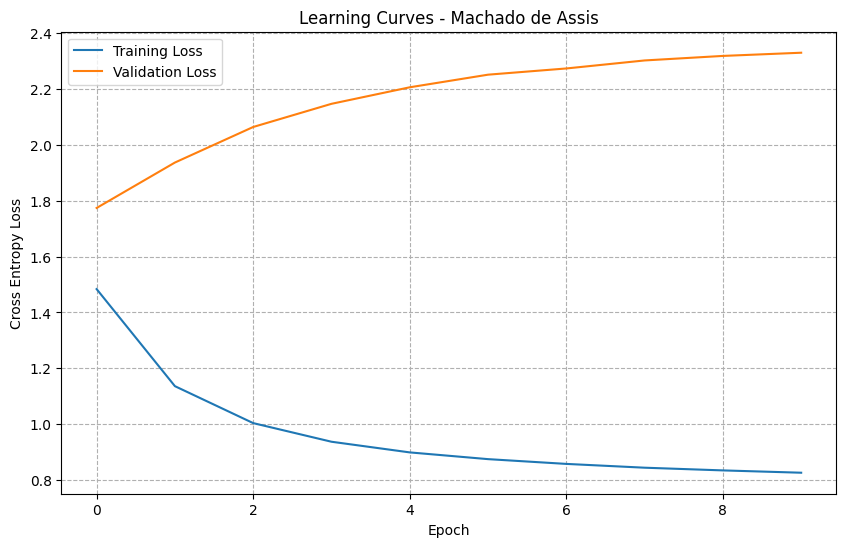

In [ ]:
# Instantiate Model, Loss, Optimizer
model = OptionalModel(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the Model
train_losses, valid_losses = train_machado(
    model, train_loader, valid_loader, criterion, optimizer,
    NUM_EPOCHS, CLIP_VALUE, DEVICE, MODEL_SAVE_PATH, PRINT_EVERY
)

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Learning Curves - Machado de Assis')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

### **Part 6.5: Text Generation**

This final part defines and uses a function to generate new text samples using the trained language model.
- **`generate_machado`**: Implements the text generation logic:
    - Sets the model to evaluation mode (`model.eval()`).
    - Initializes the hidden state.
    - Optionally primes the model by feeding a `seed_phrase` through the LSTM to update the hidden state.
    - Iteratively predicts the next character:
        - Encodes the last generated character as input.
        - Performs a forward pass to get logits and the next hidden state.
        - Applies `softmax` to logits to get probabilities.
        - Implements top-k sampling: selects the top `k` most probable next characters, renormalizes their probabilities, and samples from this smaller distribution using `torch.multinomial`. This often produces more coherent text than sampling from the full distribution.
        - Decodes the sampled index back to a character.
        - Appends the character to the generated text and uses it as input for the next step.
    - Continues until a maximum length (`max_len`) is reached.
    - Returns the generated text string.
- **Execution:**
    - Loads the best model weights saved during training (`model.load_state_dict`).
    - Calls the `generate_machado` function multiple times with a starting seed phrase (e.g., "A ") to produce text samples in the style learned from Machado de Assis's works.

In [ ]:
def generate_machado(model, char_to_int, int_to_char, seed_phrase="O ", max_len=500, top_k=5):
    """ Generates text using the trained LSTM model. """
    model.eval() # Set model to evaluation mode
    device = next(model.parameters()).device # Get device model is on
    generated_text = list(seed_phrase)
    batch_size = 1 # Generating one sequence at a time
    hidden = model.init_hidden(batch_size) # Initialize hidden state

    # Move hidden state to the correct device
    hidden = tuple([each.to(device) for each in hidden])

    # Convert seed phrase to tensor
    seed_tensor = torch.tensor([[char_to_int[c] for c in seed_phrase]], dtype=torch.long).to(device)

    # Prime the model with the seed phrase
    if len(seed_phrase) > 0:
         _, hidden = model(seed_tensor, hidden) # Update hidden state based on seed

    # Use the last character of the seed as the first input for generation
    input_char_tensor = torch.tensor([[char_to_int[generated_text[-1]]]], dtype=torch.long).to(device)

    # Generation loop
    for _ in range(max_len):
        logits, hidden = model(input_char_tensor, hidden) # Get output and next hidden

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits.squeeze() / 0.8, dim=-1).cpu() # Temp scaling optional

        # Top-k sampling
        probabilities, top_indices = torch.topk(probabilities, top_k) # Get top k probs/indices
        probabilities = probabilities / torch.sum(probabilities) # Re-normalize

        # Sample from the top-k distribution
        next_char_index = torch.multinomial(probabilities, 1).item()
        next_char_index = top_indices[next_char_index].item() # Get original index

        # Convert index to character
        next_char = int_to_char[next_char_index]

        generated_text.append(next_char) # Add character to output

        # Update input for next iteration
        input_char_tensor = torch.tensor([[next_char_index]], dtype=torch.long).to(device)

    return "".join(generated_text)


# Load the Best Model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.to(DEVICE) # Ensure model is on the correct device

# Generate Text
print("\nGenerating text samples:")
for i in range(3): # Generate 3 samples
    generated_sample = generate_machado(model, char_to_int, int_to_char, seed_phrase="A ", max_len=300)
    print(generated_sample)


Generating text samples:
A perguntar a abaixo da casa, que as maneiras algumas coisas, para as risos de aborrecer que o senhor que não se entendê-lo de um pronto a precebia dizer a mesa da capela, anteressava na casa era de alguns instantes, e a principal que tinha agradecer a mim, que estava agora a cara, que as minhas tal e
A pRINO
DMICORISSTRADORcê-jo criança a cara nem extratorinhos dias de casar a cara no caro na rua a mãe; mas não podia ser alguma coisa que eles, pareceu
com ela a mim
e os acordar para o seu dia, e queixava a mão ao sustilha e a alma contra antes da casa de casa. Era atravessado. A coisa que eu acaba
A cara conversar ao pessoas do carro a mãe em particular, e queria dizer que não pudesse, não disse. Nunca! Gavião é uma parte de aborreciam a presença do muito de parte a minha próxim que
se então era tão amigo
nova, que eles deis isto embora.
— Não lhe falou-me alguns instantes deles, a descontinuar


## Part 6.6: Analysis of Results

The results from the simplified training run provide insights into the LSTM model's learning process and limitations under these constraints.


### **Learning Curves Analysis**

The plotted learning curves show a clear trend:

- **Training Loss** decreased consistently and significantly over the 10 epochs.  
  This indicates that the model was successfully learning patterns present in the training subset of Machado de Assis's text and adjusting its weights to minimize the error on that specific data.

- **Validation Loss**, conversely, started increasing after the initial epochs.  
  This divergence between training and validation loss is a classic sign of **overfitting**. The model became too specialized in the training data and lost its ability to generalize well to unseen data (the validation set).  

This overfitting is expected given the **reduced dataset size**, **limited number of epochs**, and **simplified model architecture** used for faster execution.


### **Generated Text Analysis**

The text samples generated by the trained model reflect the observations from the learning curves:

- The model demonstrates **learning at the character level**, successfully forming word-like structures separated by spaces and occasionally using punctuation.  
  Many generated sequences resemble plausible Portuguese words.

- However, the generated text **lacks semantic coherence, grammatical correctness, and overall meaning**.  
  Invented words and repetitive patterns are present.  

This indicates that while the model learned basic **character co-occurrence patterns**, it did not capture the deeper **linguistic structures**, **style**, or **long-range dependencies** characteristic of Machado de Assis's writing, due to the overfitting and limited training.


### **Conclusion**

The implementation of the LSTM model, the data processing pipeline, the training loop including validation loss calculation, and the text generation function appear to be **functionally correct**.

- The model demonstrated its capacity to learn from the training data, as evidenced by the decreasing training loss.  
- The observed overfitting, highlighted by the increasing validation loss and the low quality of the generated text, is a **direct consequence of the necessary simplifications** made (reduced data, fewer epochs, smaller model) to achieve a reasonable execution time for this optional challenge within an academic context.
  

